<a href="https://colab.research.google.com/github/JS2387/text-mining/blob/master/climate_change_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers import BatchNormalization


In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/the-reddit-climate-change-dataset-comments.csv"
data = pd.read_csv(path)

In [4]:
 strategy = tf.distribute.get_strategy()
 print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [32]:
df = data.sample(frac = 0.01, random_state = 123)
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45433 entries, 1857107 to 3743430
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   type            45433 non-null  object 
 1   id              45433 non-null  object 
 2   subreddit.id    45433 non-null  object 
 3   subreddit.name  45433 non-null  object 
 4   subreddit.nsfw  45433 non-null  bool   
 5   created_utc     45433 non-null  int64  
 6   permalink       45433 non-null  object 
 7   body            45433 non-null  object 
 8   sentiment       45433 non-null  float64
 9   score           45433 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 3.5+ MB


In [6]:
def create_label(sentiment):
    if sentiment < 0:
        return 0 # NEGATIVE SENTIMENT
    else:
        return 1 # POSITIVE SENTIMENT

In [33]:
df['label'] = df['sentiment'].apply(create_label)
df = df[['body', 'label']]
df = df.reset_index(drop = True)
df.head()

,body,label
0,A person's beliefs and needs shift based on ci...,1
1,I guess I don't understand what that has to do...,1
2,&gt;climate change will be way worse\n\nThere ...,0
3,The fire itself may have been caused by climat...,0
4,This has been a really interesting and informa...,1


In [34]:
df.body.apply(lambda x:len(str(x).split())).max()

1852

In [7]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = roc_curve(target, predictions)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(df['body'].values,df['label'].values,
                                                     stratify=df['label'].values, test_size=0.2, random_state=123)

xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain, ytrain,
                                                  stratify=ytrain, test_size=0.25, random_state=123) # 0.25 x 0.8 = 0.2

## Tokenize

In [36]:
# using keras tokenizer here
token = Tokenizer(num_words=None)
max_len = 2000

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)

#zero pad the sequences
xtrain_pad = pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

## Simple RNN

In [37]:
%%time
with strategy.scope():
    # A simpleRNN without any pretrained embeddings and one dense layer
    model1 = Sequential()
    model1.add(Embedding(len(word_index) + 1,
                     100,
                     input_length=max_len))
    model1.add(SimpleRNN(100))
    model1.add(Dense(1, activation='sigmoid'))
    model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 2000, 100)         8328600   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 8,348,801
Trainable params: 8,348,801
Non-trainable params: 0
_________________________________________________________________
CPU times: user 84.7 ms, sys: 3.94 ms, total: 88.7 ms
Wall time: 88.1 ms


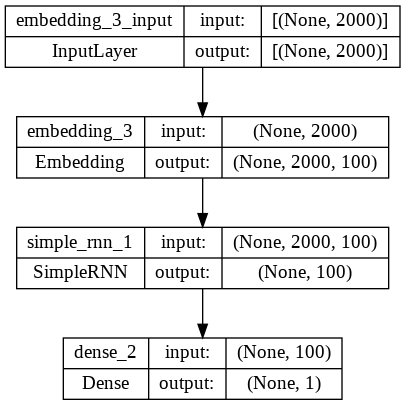

In [56]:
tf.keras.utils.plot_model(model1, to_file='simpleRNN.png', show_shapes=True, show_layer_names=True)

In [38]:
history1 = model1.fit(xtrain_pad, ytrain, epochs=3, batch_size=64*strategy.num_replicas_in_sync, verbose = 1, validation_data = (xvalid_pad, yvalid)) #Multiplying by Strategy to run on GPU or CPU

Epoch 1/3
426/426 [==============================] - 818s 2s/step - loss: 0.6880 - accuracy: 0.5362 - val_loss: 0.6829 - val_accuracy: 0.5610
Epoch 2/3
426/426 [==============================] - 820s 2s/step - loss: 0.6509 - accuracy: 0.6268 - val_loss: 0.6884 - val_accuracy: 0.5513
Epoch 3/3
426/426 [==============================] - 814s 2s/step - loss: 0.6138 - accuracy: 0.6634 - val_loss: 0.7240 - val_accuracy: 0.5513


In [39]:
scores = model1.predict(xtest_pad)
print("Auc: %.2f%%" % (roc_auc(scores,ytest)))

284/284 [==============================] - 38s 132ms/step
Auc: 0.57%


In [40]:
y_pred = scores.copy()
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.53      0.52      0.53      4307
           1       0.58      0.58      0.58      4780

    accuracy                           0.55      9087
   macro avg       0.55      0.55      0.55      9087
weighted avg       0.55      0.55      0.55      9087



In [41]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,ytest)})

## Word Embeddings from GloVe

In [23]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove*.zip
!ls
!pwd

--2023-01-15 21:15:25--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2023-01-15 21:15:26--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.11MB/s    in 6m 14s  

2023-01-15 21:21:41 (3.88 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27

In [17]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.300d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:30, 13080.33it/s]

Found 400000 word vectors.


In [25]:
embeddings_index = {}
f = open('/content/glove.twitter.27B.100d.txt','r',encoding='utf-8')
for line in tqdm(f):
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

1193514it [00:33, 35933.22it/s]

Found 1193514 word vectors.


## LSTM

In [42]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 83285/83285 [00:00<00:00, 605713.08it/s]


In [43]:
%%time
with strategy.scope():
    
    # A simple LSTM with glove embeddings and one dense layer
    model2 = Sequential()
    model2.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

    model2.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model2.add(Dense(1, activation='sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 2000, 100)         8328600   
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 8,409,101
Trainable params: 80,501
Non-trainable params: 8,328,600
_________________________________________________________________
CPU times: user 173 ms, sys: 18.4 ms, total: 192 ms
Wall time: 206 ms


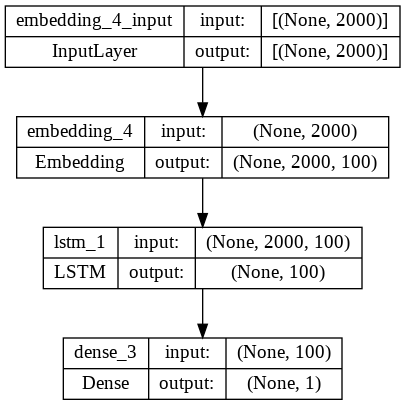

In [57]:
tf.keras.utils.plot_model(model2, to_file='LSTM.png', show_shapes=True, show_layer_names=True)

In [45]:
history2 = model2.fit(xtrain_pad, ytrain, epochs=3, batch_size=64*strategy.num_replicas_in_sync, verbose = 1, validation_data = (xvalid_pad, yvalid))

Epoch 1/3
426/426 [==============================] - 3108s 7s/step - loss: 0.6312 - accuracy: 0.6471 - val_loss: 0.6473 - val_accuracy: 0.6463
Epoch 2/3
426/426 [==============================] - 3061s 7s/step - loss: 0.5907 - accuracy: 0.6887 - val_loss: 0.5815 - val_accuracy: 0.7025
Epoch 3/3
426/426 [==============================] - 3068s 7s/step - loss: 0.5639 - accuracy: 0.7111 - val_loss: 0.5459 - val_accuracy: 0.7271


In [46]:
scores = model2.predict(xtest_pad)
print("Auc: %.2f%%" % (roc_auc(scores,ytest)))

284/284 [==============================] - 132s 465ms/step
Auc: 0.80%


In [47]:
y_pred = scores.copy()
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.66      0.70      4307
           1       0.72      0.79      0.75      4780

    accuracy                           0.73      9087
   macro avg       0.73      0.72      0.73      9087
weighted avg       0.73      0.73      0.73      9087



In [48]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,ytest)})

## GRUs

In [50]:
%%time
with strategy.scope():
    # GRU with glove embeddings and 1 dense layer
     model3 = Sequential()
     model3.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     model3.add(SpatialDropout1D(0.3))
     model3.add(GRU(100))
     model3.add(Dense(1, activation='sigmoid'))

     model3.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 2000, 100)         8328600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 2000, 100)        0         
 ropout1D)                                                       
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 8,389,301
Trainable params: 60,701
Non-trainable params: 8,328,600
_________________________________________________________________
CPU times: user 282 ms, sys: 5.91 ms, total: 288 ms
Wall time: 311 ms


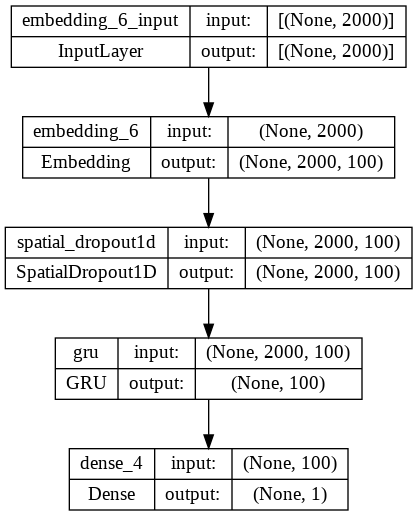

In [58]:
tf.keras.utils.plot_model(model3, to_file='GRU.png', show_shapes=True, show_layer_names=True)

In [51]:
history3 = model3.fit(xtrain_pad, ytrain, epochs=5, batch_size=64*strategy.num_replicas_in_sync, verbose = 1, validation_data = (xvalid_pad, yvalid))

Epoch 1/5
426/426 [==============================] - 42s 89ms/step - loss: 0.6619 - accuracy: 0.5968 - val_loss: 0.5902 - val_accuracy: 0.6933
Epoch 2/5
426/426 [==============================] - 34s 79ms/step - loss: 0.5843 - accuracy: 0.6925 - val_loss: 0.5299 - val_accuracy: 0.7294
Epoch 3/5
426/426 [==============================] - 34s 80ms/step - loss: 0.5472 - accuracy: 0.7219 - val_loss: 0.5086 - val_accuracy: 0.7480
Epoch 4/5
426/426 [==============================] - 35s 83ms/step - loss: 0.5235 - accuracy: 0.7347 - val_loss: 0.4974 - val_accuracy: 0.7579
Epoch 5/5
426/426 [==============================] - 35s 82ms/step - loss: 0.5078 - accuracy: 0.7496 - val_loss: 0.4921 - val_accuracy: 0.7621


In [52]:
scores = model3.predict(xtest_pad)
print("Auc: %.2f%%" % (roc_auc(scores,ytest)))

284/284 [==============================] - 7s 25ms/step
Auc: 0.84%


In [53]:
y_pred = scores.copy()
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.56      0.52      4307
           1       0.54      0.46      0.50      4780

    accuracy                           0.51      9087
   macro avg       0.51      0.51      0.51      9087
weighted avg       0.51      0.51      0.51      9087



In [54]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,ytest)})

In [55]:
y_pred

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [73]:
%%time
with strategy.scope():
    # GRU with glove embeddings and 1 dense layer and batch normalization
     model5 = Sequential()
     model5.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
     #model5.add(BatchNormalization())
     model5.add(SpatialDropout1D(0.3))
     model5.add(GRU(100))
     model5.add(Dense(1, activation='sigmoid'))

     model5.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])   
    
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 2000, 100)         8328600   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 2000, 100)        0         
 lDropout1D)                                                     
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 8,389,301
Trainable params: 60,701
Non-trainable params: 8,328,600
_________________________________________________________________
CPU times: user 271 ms, sys: 11.7 ms, total: 283 ms
Wall time: 302 ms


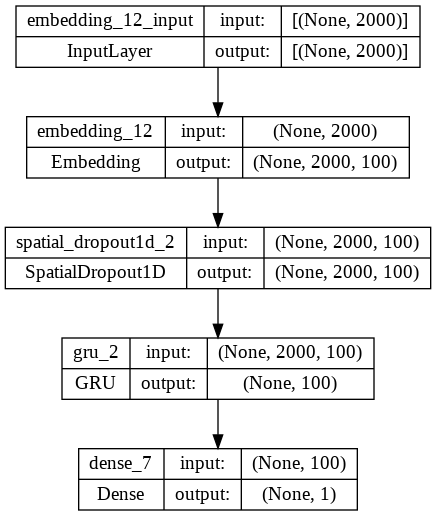

In [74]:
tf.keras.utils.plot_model(model5, to_file='GRU_BN.png', show_shapes=True, show_layer_names=True)

In [75]:
history5 = model5.fit(xtrain_pad, ytrain, epochs=15, batch_size=64*strategy.num_replicas_in_sync, verbose = 1, validation_data = (xvalid_pad, yvalid))

Epoch 1/15
426/426 [==============================] - 40s 91ms/step - loss: 0.6571 - accuracy: 0.6069 - val_loss: 0.5819 - val_accuracy: 0.6975
Epoch 2/15
426/426 [==============================] - 35s 82ms/step - loss: 0.5900 - accuracy: 0.6875 - val_loss: 0.5399 - val_accuracy: 0.7195
Epoch 3/15
426/426 [==============================] - 36s 84ms/step - loss: 0.5572 - accuracy: 0.7106 - val_loss: 0.5182 - val_accuracy: 0.7361
Epoch 4/15
426/426 [==============================] - 35s 83ms/step - loss: 0.5284 - accuracy: 0.7325 - val_loss: 0.4974 - val_accuracy: 0.7571
Epoch 5/15
426/426 [==============================] - 35s 83ms/step - loss: 0.5079 - accuracy: 0.7480 - val_loss: 0.4901 - val_accuracy: 0.7566
Epoch 6/15
426/426 [==============================] - 35s 83ms/step - loss: 0.5008 - accuracy: 0.7529 - val_loss: 0.4934 - val_accuracy: 0.7581
Epoch 7/15
426/426 [==============================] - 36s 84ms/step - loss: 0.4858 - accuracy: 0.7631 - val_loss: 0.4735 - val_accuracy:

In [76]:
scores = model5.predict(xtest_pad)
print("Auc: %.2f%%" % (roc_auc(scores,ytest)))

284/284 [==============================] - 8s 28ms/step
Auc: 0.87%


In [77]:
scores_model.append({'Model': 'GRU_15epochs','AUC_Score': roc_auc(scores,ytest)})

In [78]:
scores_model

[{'Model': 'SimpleRNN', 'AUC_Score': 0.5704923288254111},
 {'Model': 'LSTM', 'AUC_Score': 0.514629900920269},
 {'Model': 'GRU', 'AUC_Score': 0.8429991849407358},
 {'Model': 'GRU_BN', 'AUC_Score': 0.8237650006363096},
 {'Model': 'GRU_15epochs', 'AUC_Score': 0.8676709511518176}]

## Bi-Directional LSTM

In [59]:
%%time
with strategy.scope():
    # A simple bidirectional LSTM with glove embeddings and one dense layer
    model4 = Sequential()
    model4.add(Embedding(len(word_index) + 1,
                     100,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
    model4.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))

    model4.add(Dense(1,activation='sigmoid'))
    model4.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
    
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 2000, 100)         8328600   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 8,489,601
Trainable params: 161,001
Non-trainable params: 8,328,600
_________________________________________________________________
CPU times: user 306 ms, sys: 34.5 ms, total: 341 ms
Wall time: 339 ms


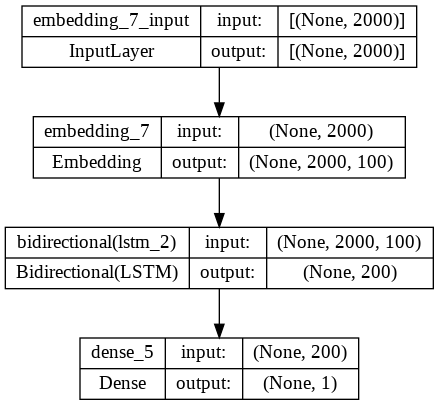

In [60]:
tf.keras.utils.plot_model(model4, to_file='BiLSTMwithGloVe.png', show_shapes=True, show_layer_names=True)

In [61]:
history4 = model4.fit(xtrain_pad, ytrain, epochs=3, batch_size=64*strategy.num_replicas_in_sync, verbose = 1, validation_data = (xvalid_pad, yvalid))

Epoch 1/5
  2/426 [..............................] - ETA: 1:40:29 - loss: 0.7013 - accuracy: 0.4531

KeyboardInterrupt: ignored

In [44]:
scores = model4.predict(xtest_pad)
print("Auc: %.2f%%" % (roc_auc(scores,ytest)))

86/86 [==============================] - 11s 129ms/step
Auc: 0.53%


In [45]:
y_pred = scores.copy()
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1
print(classification_report(yvalid,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50      1298
           1       0.54      0.54      0.54      1431

    accuracy                           0.52      2729
   macro avg       0.52      0.52      0.52      2729
weighted avg       0.52      0.52      0.52      2729



In [46]:
scores_model.append({'Model': 'Bi-directional LSTM','AUC_Score': roc_auc(scores,yvalid)})

In [47]:
scores_model

[{'Model': 'LSTM', 'AUC_Score': 0.8110418759603282},
 {'Model': 'GRU', 'AUC_Score': 0.8334329328892808},
 {'Model': 'SimpleRNN', 'AUC_Score': 0.5216822849537912},
 {'Model': 'Bi-directional LSTM', 'AUC_Score': 0.5256108144659473}]

## BERT (attempted)

In [50]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 4.0 MB/s eta 0:00:00


In [65]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from transformers import AutoTokenizer

from tokenizers import BertWordPieceTokenizer

In [53]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

df_train, df_valid = train_test_split(df_train, test_size=0.25, random_state=123) # 0.25 x 0.8 = 0.2

In [69]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer(truncation = True, max_length=maxlen)
    tokenizer(padding = True, max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [55]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192

In [70]:
# First load the real tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library


('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json',
 './tokenizer.json')

In [72]:
x_train = fast_encode(df_train.body.astype(str), tokenizer, maxlen = MAX_LEN)
x_valid = fast_encode(df_valid.body.astype(str), tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(df_test.body.astype(str), tokenizer, maxlen=MAX_LEN)

y_train = df_train.label.values
y_valid = df_valid.label.values

ValueError: ignored